<a href="https://colab.research.google.com/github/sujan123123/CNN/blob/master/ImageSearchingUsingAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import numpy as np

In [3]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1
		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim, name="encoded")(x)
	# start building the decoder model which will accept the
		# output of the encoder as its inputs
		x = Dense(np.prod(volumeSize[1:]))(latent)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid", name="decoded")(x)
		# construct our autoencoder model
		autoencoder = Model(inputs, outputs, name="autoencoder")
		# return the autoencoder model
		return autoencoder

In [4]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None
	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")
		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])
		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output
		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])
	# return the output images
	return outputs

In [5]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
autoencoder = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step
[INFO] building autoencoder...
Epoch 1/20
1875/1875 [==============================] - 115s 61ms/step - loss: 0.0191 - val_loss: 0.0107
Epoch 2/20
1875/1875 [==============================] - 115s 61ms/step - loss: 0.0104 - val_loss: 0.0094
Epoch 3/20
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 4/20
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 5/20
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 6/20
1875/1875 [==============================] - 113s 60ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 7/20
1875/1875 [==============================] - 117s 62ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 8/20
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 9/20
1875/1875 [==========

[INFO] making predictions...
[INFO] saving autoencoder...


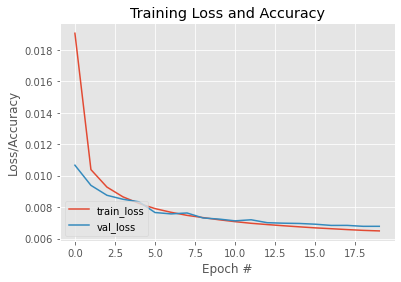

In [8]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
#cv2.imwrite(args["vis"], vis)
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")

In [41]:
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)
# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(trainX)

[INFO] encoding testing images...


In [42]:
indexes = list(range(0, trainX.shape[0]))
data = {"indexes": indexes, "features": features}

In [43]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)
 
def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []
	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))
	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]
	# return the list of results
	return results

In [44]:
from imutils import build_montages

encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)
# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(testX)
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=10,
	replace=False)
# loop over the testing indexes
for i in queryIdxs:
	# take the features for the current image, find all similar
	# images in our dataset, and then initialize our list of result
	# images
	queryFeatures = features[i]
	results = perform_search(queryFeatures, data, maxResults=225)
	images = []
	# loop over the results
	for (d, j) in results:
		# grab the result image, convert it back to the range
		# [0, 255], and then update the images list
		image = (trainX[j] * 255).astype("uint8")
		image = np.dstack([image] * 3)
		images.append(image)
	# display the query image
	query = (testX[i] * 255).astype("uint8")
	#cv2.imshow("Query", query)
	# build a montage from the results and display it
	montage = build_montages(images, (28, 28), (15, 15))[0]

[INFO] encoding testing images...


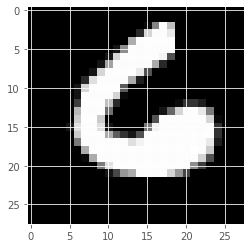

In [45]:
plt.imshow(image)

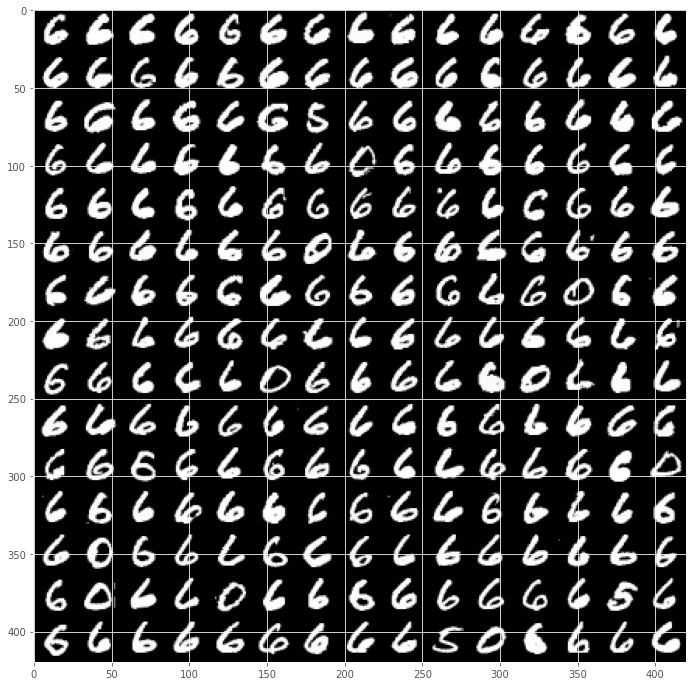

In [47]:
plt.figure(figsize=(12,12,))
plt.imshow(montage)